# Incorporating Cometary Activity

The goal of this notebook is to demonstrate the use of lightcurves within `sorcha`.

This will be done in two different ways:
- We will use the community tools part of the `sorcha-addons`(https://github.com/dirac-institute/sorcha-addons) package
- We will implement a custom lightcurve, and use it inside the code

The idea is that the user can, in principle, implement their own lightcurves, and incorporate them in their simulation. The goal of `sorcha-addons` is for both the development team, as well as for the community, to share their implementations of custom lightcurve models. 

In [133]:
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter

This notebook will not use a realistic set of observations (as in the `demo_ApparentMagnitudeValidation` notebook), but rather create a toy scenario with a simple to understand and interpret set of results. The general structure of the notebook will be the same.

We will create a dataframe for observations in a similar structure as in the `demo_ApparentMagnitudeValidation` notebook:

In [134]:
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": np.linspace(
            0, 100, 1001
        ),  # time of observation - note these values are bogus, we only care about the Delta t for this demo
        "H_filter": 15 * np.ones(1001),
        # starting at 30 au and coming inward to 5 au 
        "Range_LTC_km": 1.495978707e8 * np.flip(np.linspace(  4, 30, 1001)), # au
        "Obj_Sun_LTC_km": 1.495978707e8 * np.flip(np.linspace(5, 30, 1001)),  #  au
        "phase_deg": np.zeros(1001), 
        #keeping the same phase although this is unphysical so that we can look at just the effects of activity on the brightness of the object
        "optFilter": np.full(1001,'r',dtype=str), 
    }
)  

In [135]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter
0,0.0,15.0,4.487936e+09,4.487936e+09,0.0,r
1,0.1,15.0,4.484047e+09,4.484196e+09,0.0,r
2,0.2,15.0,4.480157e+09,4.480456e+09,0.0,r
3,0.3,15.0,4.476267e+09,4.476716e+09,0.0,r
4,0.4,15.0,4.472378e+09,4.472976e+09,0.0,r
...,...,...,...,...,...,...
996,99.6,15.0,6.139497e+08,7.629491e+08,0.0,r
997,99.7,15.0,6.100601e+08,7.592092e+08,0.0,r
998,99.8,15.0,6.061706e+08,7.554692e+08,0.0,r
999,99.9,15.0,6.022810e+08,7.517293e+08,0.0,r


Now we calculate the magnitude of the nuceleus assuming no phase curve model in PPCalculateApparentMagnitudeInFilter.

In [136]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "none", "r", "Simple_mag")

In [137]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter,Simple_mag
0,0.0,15.0,4.487936e+09,4.487936e+09,0.0,r,29.771213
1,0.1,15.0,4.484047e+09,4.484196e+09,0.0,r,29.767519
2,0.2,15.0,4.480157e+09,4.480456e+09,0.0,r,29.763823
3,0.3,15.0,4.476267e+09,4.476716e+09,0.0,r,29.760124
4,0.4,15.0,4.472378e+09,4.472976e+09,0.0,r,29.756421
...,...,...,...,...,...,...,...
996,99.6,15.0,6.139497e+08,7.629491e+08,0.0,r,21.603888
997,99.7,15.0,6.100601e+08,7.592092e+08,0.0,r,21.579416
998,99.8,15.0,6.061706e+08,7.554692e+08,0.0,r,21.554804
999,99.9,15.0,6.022810e+08,7.517293e+08,0.0,r,21.530049


Now we can plot the magnitudes and compare them.

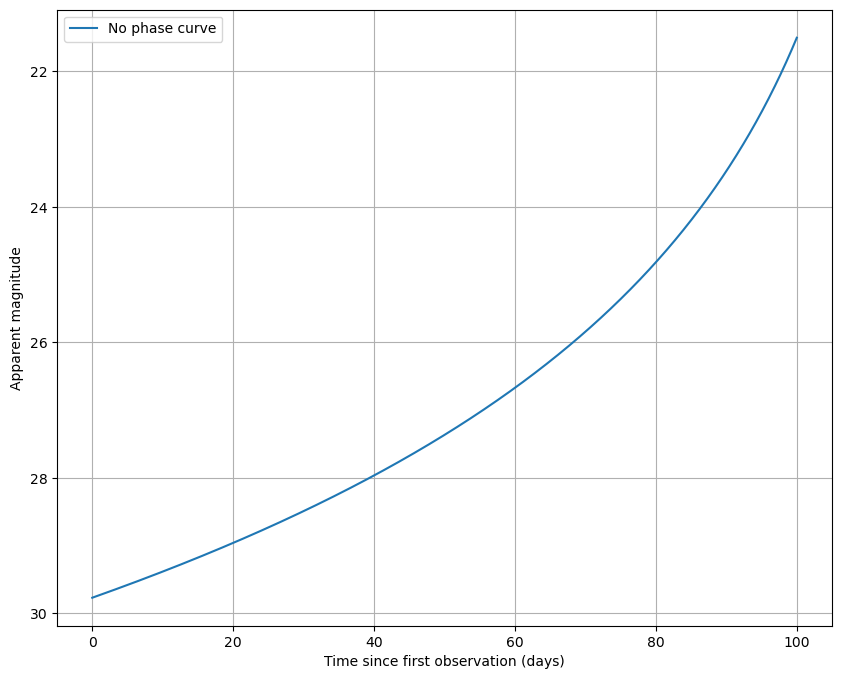

In [138]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(observations_df["fieldMJD_TAI"], observations_df["Simple_mag"], linestyle="-", label="No phase curve")

ax.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

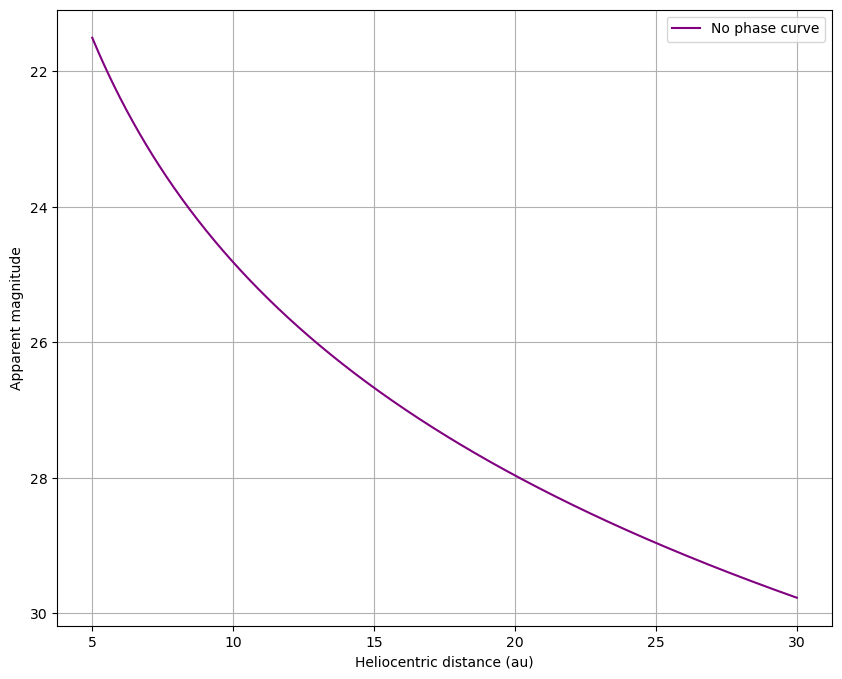

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(observations_df["Obj_Sun_LTC_km"]/1.495978707e8 , observations_df["Simple_mag"], linestyle="-", label="No phase curve", color='purple')

ax.legend()
ax.set_ylabel("Apparent magnitude")
ax.set_xlabel("Heliocentric distance (au)")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

The effect of the lightcurve is to add an extra term to the apparent magnitude, that, in principle, can be a function of the characteristics of the observations, such as time of observation, phase angle or topocentric and heliocentric distances. The entire `observational_df` dataframe is exposed to the lightcurve, so any dependencies can be added. 

Let's use the basic sinusoidal lightcurve from `sorcha_addons`. We need the following columns in our dataframe:

    * ``LCA`` - lightcurve amplitude [magnitudes].
    * ``Period`` - period of the sinusoidal oscillation [days]. Should be a positive value.
    * ``Time0`` - phase for the light curve [days].

Let's create a lightcurve with a period of 20 days, phased so that the first observation is at zero variation, and with 0.5 mag peak-to-peak amplitude.

In [140]:
from sorcha_addons.activity.lsst_comet.lsst_comet_activity import LSSTCometActivity
from sorcha.activity.activity_registration import update_activity_subclasses

update_activity_subclasses()

In [149]:
observations_df["afrho1"] = 150
observations_df["k"] =-0.5


In [150]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "none", "r",cometary_activity_choice="lsst_comet")

In [151]:
observations_df

,fieldMJD_TAI,H_filter,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,optFilter,Simple_mag,afrho1,k,trailedSourceMagTrue,coma_magnitude
0,0.0,15.0,4.487936e+09,4.487936e+09,0.0,r,29.771213,150,-0.5,28.037727,28.283515
1,0.1,15.0,4.484047e+09,4.484196e+09,0.0,r,29.767519,150,-0.5,28.034424,28.280311
2,0.2,15.0,4.480157e+09,4.480456e+09,0.0,r,29.763823,150,-0.5,28.031117,28.277104
3,0.3,15.0,4.476267e+09,4.476716e+09,0.0,r,29.760124,150,-0.5,28.027808,28.273894
4,0.4,15.0,4.472378e+09,4.472976e+09,0.0,r,29.756421,150,-0.5,28.024497,28.270682
...,...,...,...,...,...,...,...,...,...,...,...
996,99.6,15.0,6.139497e+08,7.629491e+08,0.0,r,21.603888,150,-0.5,20.696743,21.314036
997,99.7,15.0,6.100601e+08,7.592092e+08,0.0,r,21.579416,150,-0.5,20.674667,21.293797
998,99.8,15.0,6.061706e+08,7.554692e+08,0.0,r,21.554804,150,-0.5,20.652463,21.273449
999,99.9,15.0,6.022810e+08,7.517293e+08,0.0,r,21.530049,150,-0.5,20.630130,21.252989


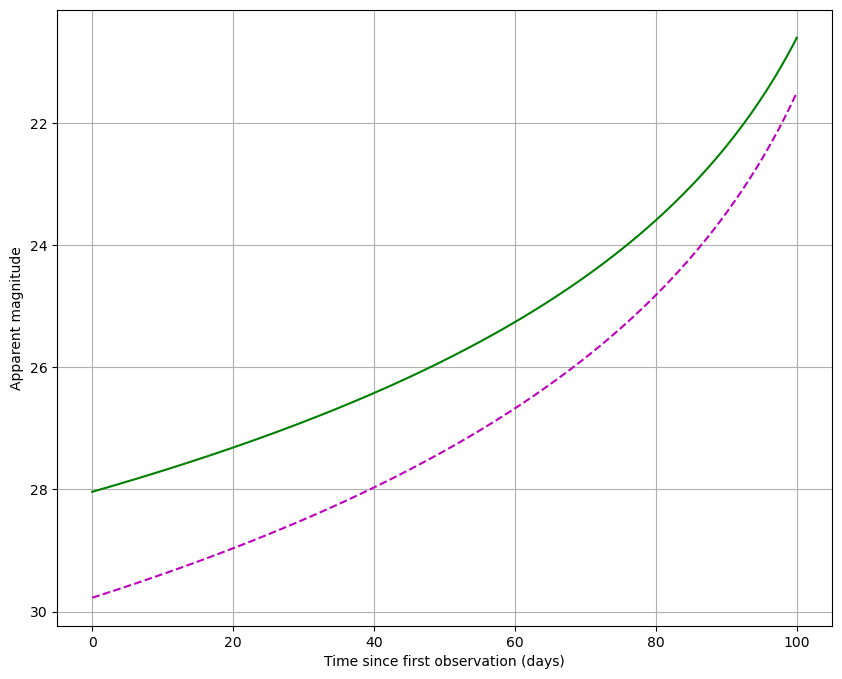

In [152]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["Simple_mag"],
    linestyle="--",
    label="__none__",
    color="m",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["trailedSourceMagTrue"], linestyle="-", label="__none__", color="g"
)

ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()